In [6]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

"""
Start with symmetric system and rank parameters by sensitivity. There is a lot of them!
"""


def hill_act(X, K, n):
    return X**n/(K**n + X**n)
def hill_inh(X, K, n):
    return K**n/(K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)
    
    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

# Define parameter values
params = {
    'a': 10.0, 'b': 1.0, 'c': 10.0, 'd': 1.0, 'e': 10.0, 'f': 1.0, 'g': 10.0, 'h': 10.0, 'i': 0.5, 'j': 10.0,
    'k': 10.0, 'l': 0.5, 'KMxy1': 10.0, 'KMxy2': 10.0, 'KM11': 10.0, 'KM12': 1.0, 'KM1x': 10.0, 'KM1y': 5.0, 
    'KM22': 10.0, 'KM21': 1.0, 'KM2x': 10.0, 'KM2y': 5.0, 'nx': 2, 'n11': 2, 'n12': 2, 'n1x': 2, 'n1y': 2, 
    'n22': 2, 'n21': 2, 'n2x': 2, 'n2y': 2
}
# Initial conditions
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]

# Time points for integration
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Integrate the ODEs
solution = solve_ivp(lambda t, y: rhs(y, t, **params), t_span, initial_conditions, t_eval=t_eval)

# Extract the solution for z1 and z2
z1_solution = solution.y[3]
z2_solution = solution.y[4]

# Perform sensitivity analysis using finite differences
sensitivity_eps = 1e-6
sensitivity_matrix = np.zeros((len(z1_solution), len(params)))

for i, param_name in enumerate(params):
    perturbed_params = params.copy()
    perturbed_params[param_name] += sensitivity_eps

    perturbed_solution = solve_ivp(lambda t, y: rhs(y, t, **perturbed_params), t_span, initial_conditions, t_eval=t_eval)
    perturbed_z1_solution = perturbed_solution.y[3]
    perturbed_z2_solution = perturbed_solution.y[4]

    sensitivity_matrix[:, i] = ((perturbed_z1_solution - z1_solution) + (perturbed_z2_solution - z2_solution)) / (2 * sensitivity_eps)

# Print or analyze the sensitivity results
print("Sensitivity Matrix:")
print(np.unravel_index(np.argmax(sensitivity_matrix), sensitivity_matrix.shape))
ordered_keys = np.argsort(sensitivity_matrix[-1,:])
print(ordered_keys)

Sensitivity Matrix:
(99, 3)
[ 8 11 16 20  2  4  1 28 24 27 23 18 14 29 25  7 10  0 26 30 22 19 15 13
 12  9  6 17 21  5  3]


<Figure size 640x480 with 0 Axes>

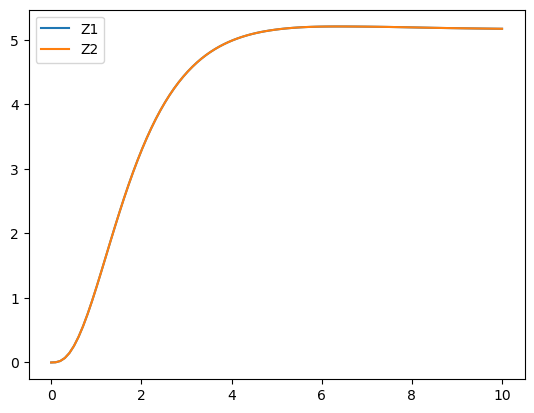

<Figure size 640x480 with 0 Axes>

In [7]:
plt.plot(t_eval, z1_solution)
plt.plot(t_eval, z2_solution)
plt.legend(['Z1', 'Z2'])
plt.figure()

In [8]:
params = {
    'a': 10.0, 'b': 1.0, 'c': 10.0, 'd': 1.0, 'e': 10.0, 'f': 1.0, 'g': 10.0, 'h': 0.5, 'i': 10.0, 'j': 10.0,
    'k': 0.5, 'l': 10.0, 'KMxy1': 10.0, 'KMxy2': 10.0, 'KM11': 1.0, 'KM12': 0.5, 'KM1x': 10.0, 'KM1y': 5.0, 
    'KM22': 10.0, 'KM21': 1.0, 'KM2x': 10.0, 'KM2y': 5.0, 'nx': 2, 'n11': 2, 'n12': 2, 'n1x': 2, 'n1y': 2, 
    'n22': 2, 'n21': 2, 'n2x': 2, 'n2y': 2
}

reference = {i: key for i, key in enumerate(params)}

print("New Dictionary:")
for key in ordered_keys:
    print(reference[key])

New Dictionary:
i
l
KM1x
KM2x
c
e
b
n21
n12
n22
n11
KM22
KM11
n2x
n1x
h
k
a
n1y
n2y
nx
KM21
KM12
KMxy2
KMxy1
j
g
KM1y
KM2y
f
d


In [18]:
# import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

"""
Perturb parameter pairs and then eventually compare parameters vs slope of dx_dt (with the parameter a)
"""


def hill_act(X, K, n):
    return X**n/(K**n + X**n)
def hill_inh(X, K, n):
    return K**n/(K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)
    
    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

def calc(a, r2):
    """
    Brute Force Monte Carlo Parameter Sensitivity Analysis
    """
    # Time points we want for the solution
    t = np.linspace(0, 10, 1000)
   
    # Initial condition
    xyz_0 = np.array([2.0, 2.0, 2.0, 0.0, 0.0])

    # Parameters
    b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.5, 10.0, 10.0, 0.5]
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 10.0, 2.5, 10.0, 10.0]


    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(9, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    x, y1, y2, z1, z2 = xyz.transpose()
    return z1[-1], z2[-1]

y1array=np.linspace(0.1,20,100)
y2array=np.linspace(0.1,20,100)
z1xarray=np.empty((100,100))
z2yarray=np.empty((100,100))

for i,R1 in enumerate(y1array):
    for j,R2 in enumerate(y2array):
        values = calc(a=R1, r2=R2)
        z1xarray[i,j]=values[0]
        z2yarray[i,j]=values[1]

Z=z1xarray-z2yarray
# Z[Z<-1] = -1
# Z[Z>1] = 1

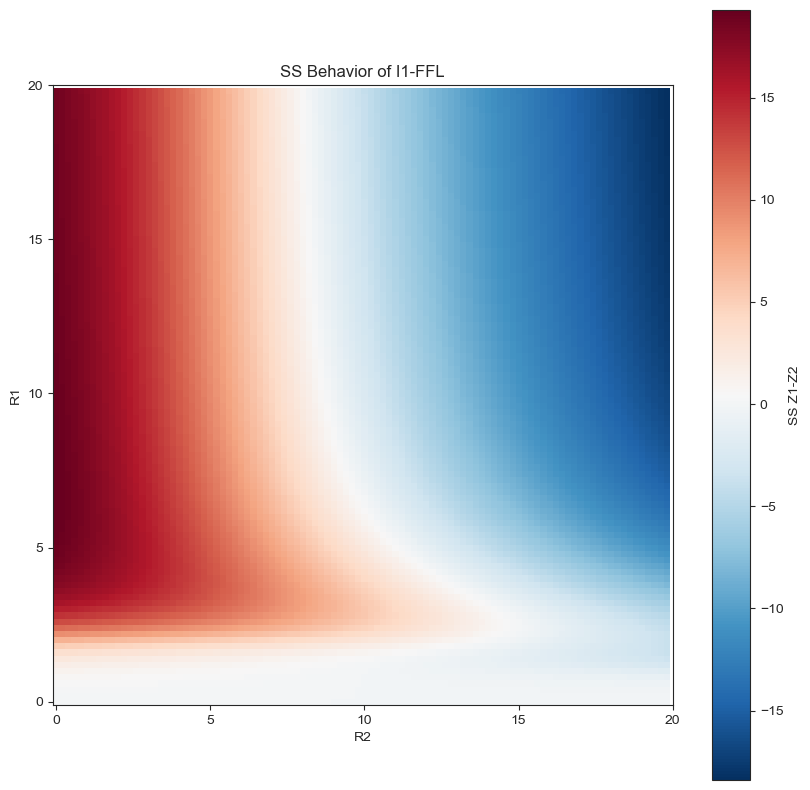

In [15]:
x_ticks = [0, 5, 10, 15, 20]
y_ticks = [0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(figsize=(10, 10))
pc = axs.imshow(Z, origin='lower', cmap='RdBu_r')#, vmin=-5, vmax=5)
axs.set_xticks([0, 25, 50, 75, 100], labels=x_ticks)
axs.set_yticks([0, 25, 50, 75, 100], labels=x_ticks)
axs.set_xlabel('R2')
axs.set_ylabel('R1')
cbar = fig.colorbar(pc)
cbar.set_label('SS Z1-Z2')
axs.set_title(f'SS Behavior of I1-FFL')
plt.show()

Z1 = 15.1002513858101
Z1 = 7.0608099369385
Z1 = 6.052702910026279
Z2 = 3.300969432004018
Z2 = 12.97641454741439
Z2 = 13.865510816721072


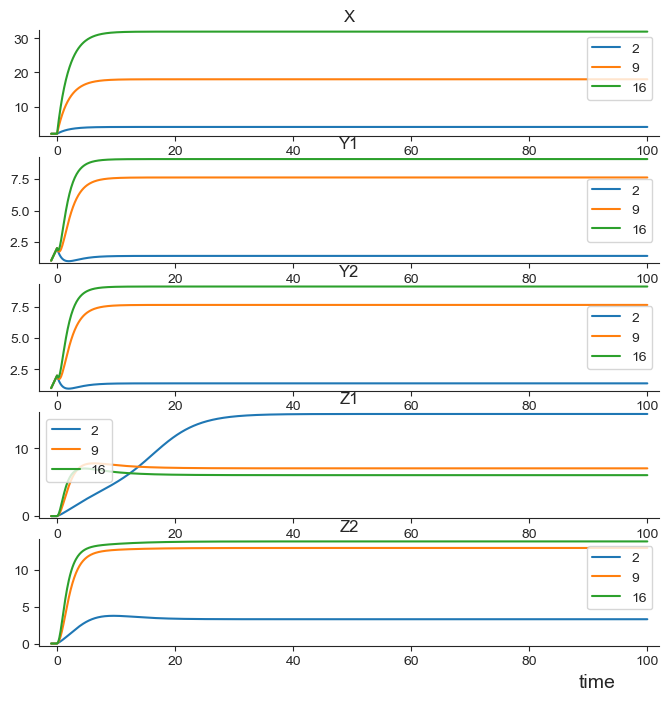

In [17]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

"""
The same thing as above but with 2 nested FFLs instead.
"""

sns.set_style('ticks')
%matplotlib inline

# Time points we want for the solution
t = np.linspace(0, 100, 1000)

# Initial condition
xyz_0 = np.array([2.0, 2.0, 2.0, 0.0, 0.0])

# Parameters
Fs = [2, 9, 16]
b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.5, 12.0, 10.0, 0.5]
nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 10.0, 2.5, 10.0, 10.0]


# Keeping Track of the final values:
xs = []
y1s = []
y2s = []
z1s = []
z2s = []

for F in Fs:
    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(F, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    # Pluck out y and z
    x, y1, y2, z1, z2 = xyz.transpose()

    # Append the pre-fold change steady state
    x = np.insert(x, 0, 2.0)
    y1 = np.insert(y1, 0, 1.0)
    y2 = np.insert(y2, 0, 1.0)
    z1 = np.insert(z1, 0, 0.0)
    z2 = np.insert(z2, 0, 0.0)
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    z1s.append(z1)
    z2s.append(z2)
t = np.insert(t, 0, -1.0)

# Generate x
#x = 2.0 + 2.0 * (t > 0.0).astype(dtype=float)
# Plot the results
fig, ax = plt.subplots(5, 1, figsize=(8, 8))
for y in y1s:
    ax[1].set_title('Y1')
    ax[1].plot(t, y, '-')
for y in y2s:
    ax[2].set_title('Y2')
    ax[2].plot(t, y, '-')
for x in xs:
    ax[0].set_title('X')
    ax[0].plot(t, x, '-')
for z1 in z1s:
    ax[3].set_title('Z1')
    ax[3].plot(t, z1, '-')
    print(f'Z1 = {z1[-1]}')
for z2 in z2s:
    ax[4].set_title('Z2')
    ax[4].plot(t, z2, '-')
    print(f'Z2 = {z2[-1]}')
for i in range(ax.size):
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
    ax[i].margins(0.02)
    ax[i].set_xlabel('time', x=.9, fontsize=14)
    ax[i].legend(Fs)
    ax[i].yaxis.set_label_coords(-0.05, 0.9) 
sns.despine(offset=0.1)